<div style="background-color: #ccffcc; padding: 10px;"> 
    <h1> Physics Informed Neural Networks Part 2</h1>
    <h2> 1D Heat Equation PINNs Example </h2>
</div>    

# Overview

This notebook is based on two papers: *[Physics-Informed Neural Networks:  A Deep LearningFramework for Solving Forward and Inverse ProblemsInvolving Nonlinear Partial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999118307125)* and *[Hidden Physics Models:  Machine Learning of NonlinearPartial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999117309014)* with the help of  Fergus Shone and Michael Macraild.

These tutorials will go through solving Partial Differential Equations using Physics Informed Neural Networks focusing on the 1D Heat Equation and a more complex example using the Navier Stokes Equation

**This introduction section is replicated in all PINN tutorial notebooks (please skip if you've already been through)** 


    
</div>

<div style="background-color: #ccffcc; padding: 10px;">

<h1>Physics Informed Neural Networks</h1>

For a typical Neural Network using algorithms like gradient descent to look for a hypothesis, data is the only guide, however if the data is noisy or sparse and we already have governing physical models we can use the knowledge we already know to optimize and inform the algorithms. This can be done via [feature engineering](https://www.ibm.com/think/topics/feature-engineering) or by adding a physical inconsistency term to the loss function.


<a href="https://towardsdatascience.com/physics-guided-neural-networks-pgnns-8fe9dbad9414">
<img src="https://miro.medium.com/max/700/1*uM2Qh4PFQLWLLI_KHbgaVw.png">
</a>   
  
 
## The very basics

If you know nothing about neural networks, there is a [toy neural network python code example](https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS/tree/main/ToyNeuralNetwork) included in the [LIFD ENV ML Notebooks Repository]( https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS). Creating a 2-layer neural network to illustrate the fundamentals of how Neural Networks work and the equivalent code using the Python machine learning library [Pytorch](https://pytorch.org/). 

    
## Recommended reading 
    
The in-depth theory behind neural networks will not be covered here as this tutorial is focusing on application of machine learning methods. If you wish to learn more here are some great starting points.   


* [Introduction to Neural Networks](https://victorzhou.com/blog/intro-to-neural-networks/)
* [Maziar Rassi's Physics informed GitHub web Page](https://maziarraissi.github.io/PINNs/)

</div>


<hr>


<div style="background-color: #e6ccff; padding: 10px;">
    
<h1> Machine Learning Theory </h1>
<a href="https://victorzhou.com/series/neural-networks-from-scratch/">
<img src="https://victorzhou.com/media/nn-series/network.svg">
</a>

    
## Physics informed Neural Networks

Neural networks work by using lots of data to calculate weights and biases from data alone to minimise the loss function enabling them to act as universal function approximators. However these loose their robustness when data is limited. However by using know physical laws or empirical validated relationships the solutions from neural networks can be sufficiently constrained by disregarding non realistic solutions.
    
A Physics Informed Neural Network considers a parameterized and nonlinear partial differential equation in the general form;

\begin{align}
u_t + \mathcal{N}[u; \lambda]  = 0,  x \in \Omega, t \in [0,T],\\
\end{align}


where $\mathcal{u(t,x)}$ denores the hidden solution, $\mathcal{N}$ is a nonlinear differential operator acting on $u$, $\mathcal{\lambda}$ and $\Omega$ is a subset of $\mathbb{R}^D$ (the perscribed data). This set up an encapuslate a wide range of problems such as diffusion processes, conservation laws,  advection-diffusion-reaction  systems,  and  kinetic  equations and conservation laws. 

Here we will go though this for the 1D heat equation and Navier stokes equations


</div>    

<div style="background-color: #cce5ff; padding: 10px;">

<h1> Python </h1>

## PyTorch
    
There are many machine learning Python libraries available, [PyTorch](https://pytorch.org/) a is one such library the original code for this tutorial is in Tensorflow, if you are interested in the difference please take a look [here](https://opencv.org/blog/pytorch-vs-tensorflow/). If you have GPUs on the machine you are using Pytorch will automatically use them and run the code even faster! This will work automatically with google co-lab if using your own machine please ensure that the GPU enabled PyTorch is installed 

## Further Reading

* [Running Jupyter Notebooks](https://jupyter.readthedocs.io/en/latest/running.html#running)
* [PyTorch optimizers](https://nbviewer.org/github/bentrevett/a-tour-of-pytorch-optimizers/blob/main/a-tour-of-pytorch-optimizers.ipynb)



</div>
    
<hr>

<div style="background-color: #f4b85d; padding: 10px;">
    
<h1> Requirements </h1>

These notebooks should run with the following requirements satisfied

<h2> Python Packages: </h2>

* Python 3
* PyTorch
* NumPy 
* Matplotlib
* SciPy

<h2> Data Requirements</h2>
    
This notebook refers to some data included in the GitHub repository
    
</div>


**Contents:**

1. 1D Heat Equation Non ML Example
2. **1D Heat Equation PINN Example**
    * [1D Heat Equation Forwards](#1D-Heat-Equation-Forwards)
    * [1D Heat Equation Inverse](#1D-Heat-Equation-Inverse)
3. Navier-Stokes PINNs discovery of PDEs




<div style="background-color: #cce5ff; padding: 10px;">
Load in all required modules (including some auxillary code) and turn off warnings. 
</div>

In [1]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import scipy.sparse as sp
import scipy.sparse.linalg as la
from pyDOE import lhs

<hr>

# Reconstructing the entire solution to the 1D heat equation using Neural Networks

<div style="background-color: #ccffcc; padding: 10px;">

**Model Problem: 1D Heat Equation**

We begin by describing the first model problem - the one-dimensional heat equation. 

The heat equation is the prototypical parabolic partial differential equation and can be applied to modelling the diffusion of heat through a given region. Read more about the heat equation here: [https://en.wikipedia.org/wiki/Heat_equation](https://en.wikipedia.org/wiki/Heat_equation).

In 1D, the heat equation can be written as:

\begin{equation}
\frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2 },
\end{equation}
    
where $k$ is a material parameter called the coefficient of thermal diffusivity.

This equation can be solved using numerical methods, such as finite differences or finite elements. For this notebook, we will solve for $u(x,t)$ the above equation numerically on a domain of $x \in [0,1]$ and $t \in [0, 0.25]$.

The procedure in this notebook is the following:
- read in a dataset that describes an exact solution to the heat equation. This is treated as the benchmark to which any reconstruction is compared.
- downsample the dataset to get a sparse collection of "measurements".
- Using this sparse dataset, with knowledge of the physics, attempt to reconstruct the entire solution.
- Evaluating this solution at $t=0$ gives the initial profile, thus solving the inverse problem of finding the initial state.
</div>

<div style="background-color: #e6ccff; padding: 10px;">

# PINNs
    
Here we will describe the architecture of the PINN we use to solve the 1D heat equation in this notebook. 
![PINNS.png](PINNS.png)
    
    
`Net U` in the above diagram is the neural network approximation that maps $(x,t) \mapsto u$. The notation $\sigma$ represents the biases and weights for the each neuron of the network, which are fed into the activation functions. These $\sigma$ values are the network parameters that are updated after each iteration. AD means Automatic Differentiation: this is the chain rule-based differentiation procedure that allows for differentiation of network outputs with respect to its inputs, e.g. differentiating $u$ with respect to $x$, or calculating $\frac{\partial u}{\partial x}$. The I node in the AD section represents the identity operation, i.e. keeping $u$ fixed without applying any differentiation. 

After the automatic differentiation part of the network, we have two separate loss function components: the data loss and the PDE loss. The data loss term is calculated by finding the difference between the network prediction $u$ and the ground truth values, which could come from simulation or experiment. The data loss term enforces the network outputs to match known data points, which are represented by the pink box labelled "Data". The PDE loss term is where we add the "physics-informed" part of the network. Using automatic differentiation, we are able to calculate derivatives of our network outputs, and so we are able to construct a loss function that enforces the network to match the PDE that is known to govern the system. In this case, the PDE loss term is defined as:
 
\begin{equation}
f = \frac{\partial u}{\partial t} - k \frac{\partial^2 u}{\partial x^2 },
\end{equation}
    
where f is the residual of the 1D heat equation. By demanding that $f$ is minimised, we ensure that the network outputs approximately obey the underlying PDE that governs the system. We then calculate the total loss of the system as a sum of the data loss and the PDE loss.

The loss is calculated after each pass through the network and the weights and biases are updated using a gradient descent step. 
    
</div>

<div style="background-color: #ccffcc; padding: 10px;">

# Configuring the network
      
A feedforward neural network of the following structure is assumed:
- the input layer (with two inputs: $x$ and $t$) takes 2D data $(x,t)$ scaled elementwise to lie in the interval $[-1, 1]^2$,
- this is followed by 8 fully connected layers each containing 20 neurons and each using a hyperbolic tangent activation function,
- one fully connected output layer with a single neuron.

We can count up the number of unknowns:

- The first fully connected layer has 20 neurons, each of which has two inputs and one bias term, a total of $20 \cdot 3 = 60$ unknowns.
- The remaining 7 fully connected layers each have 20 neurons with 20 inputs and a bias term, a total of $7 \cdot 20 \cdot 21=2940$ unknowns.
- The final output layer has 1 neuron with 20 inputs and one bias, a total of 21 unknowns.

Overall, the network has 3021 unknown weights and bias terms.
    

</div>

In [3]:
# structure of network: two inputs (x,t) and one output u
# 8 fully connected layers with 20 nodes per layer
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

 <div style="background-color: #cce5ff; padding: 10px;">
    
# Sampling of data and collocation 

We make the choices of:
- `N_u` (e.g. 100) data points that will constrain the network 
- `N_f` collocation points (e.g. 3000) to implement the physics-informed constraint.
- `k=1` as the coefficient of diffusivity

Once you have run through the notebook once you may wish to alter any of the sampling or network configuration parameters.

Note that in this example we have more constraints on the network (3100) than free parameters (3021), but this will change depending on network configuration. 
</div>


In [4]:
k = 1
N_u = 100  # number of data points
N_f = 3000 # Collocation points 

<hr>
<div style="background-color: #ccffcc; padding: 10px;">
    
###  Reformat input data  
    
The data comes from a file, containing lists of x and t and the solution on the associated grid.
Unfortunately we need it in a different format!

Variables that are defined here:

`Exact` - this is the solution read in from the file. It is the benchmark to which we will compare any reconstruction.

`X_star` - a vector of (x,t) coordinate pairs. This contains the boundary points (note this for later!)

`u_star` - the associated solution (a reformatted version of `Exact`)

`lb`: Vector containing the lower bound of all of the coordinate variables, e.g. $x_{min}$, $t_{min}$.

`ub`: Vector containing the upper bound of all of the coordinate variables, e.g. $x_{max}$, $t_{max}$.


</div>

In [5]:
data = scipy.io.loadmat("Data/heatEquation_data.mat") # this data is from the PINNs paper
t = data['t'].flatten()[:,None] # read in t and flatten into column vector
x = data['x'].flatten()[:,None] # read in x and flatten into column vector
 # Exact represents the exact solution to the problem, from the data provided
Exact = np.real(data['usol']).T # Exact has structure of nt times nx

print("usol shape (nt, nx) = ", Exact.shape)

# We need to find all the x,t coordinate pairs in the domain
X, T = np.meshgrid(x,t)

# Flatten the coordinate grid into pairs of x,t coordinates
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) # coordinates x,t
u_star = Exact.flatten()[:,None]   # corresponding solution value with each coordinate            


print("X has shape ", X.shape, ", X_star has shape ", X_star.shape)
    
# Domain bounds (-1,1)
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)  

print("Lower bounds of x,t: ", lb)
print("Upper bounds of x,t: ", ub)
print('')
print('The first few entries of X_star are:')
print( X_star[0:5] )

print('')
print('The first few entries of u_star are:')
print( u_star[0:5] )


usol shape (nt, nx) =  (51, 101)
X has shape  (51, 101) , X_star has shape  (5151, 2)
Lower bounds of x,t:  [0. 0.]
Upper bounds of x,t:  [1.   0.25]

The first few entries of X_star are:
[[0.   0.  ]
 [0.01 0.  ]
 [0.02 0.  ]
 [0.03 0.  ]
 [0.04 0.  ]]

The first few entries of u_star are:
[[0.  ]
 [0.01]
 [0.02]
 [0.03]
 [0.04]]


<div style="background-color: #ccffcc; padding: 10px;">

## Select collocation points

We now randomly select the `N_f` collocation points for the physics constraints. We do this using Latin Hypercube Sampling
https://en.wikipedia.org/wiki/Latin_hypercube_sampling

producing:
-  `X_f_train` the coordinates of the collocation set

## Select data points

Randomly select `N_u` points from the original dataset, producing:
-  `X_u_train` the coordinates of the training set
-  `u_train` the corresponding value of the solution value.

</div>

In [6]:
## train using internal points
#X_u_train = X_star
#u_train = u_star

## Generate collocation points using Latin Hypercube sampling within the bounds of the spatio-temporal coordinates
# Generate N_f x,t coordinates within range of upper and lower bounds
X_f_train = lb + (ub-lb)*lhs(2, N_f) # the 2 denotes the number of coordinates we have - x,t 

## In addition, we add the X_u_train co-ordinates from the boundaries to the X_f coordinate set
#X_f_train = np.vstack((X_f_train, X_u_train)) # stack up all training x,t coordinates for u and f 

## We downsample the original data to leave N_u randomly distributed points
## 
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

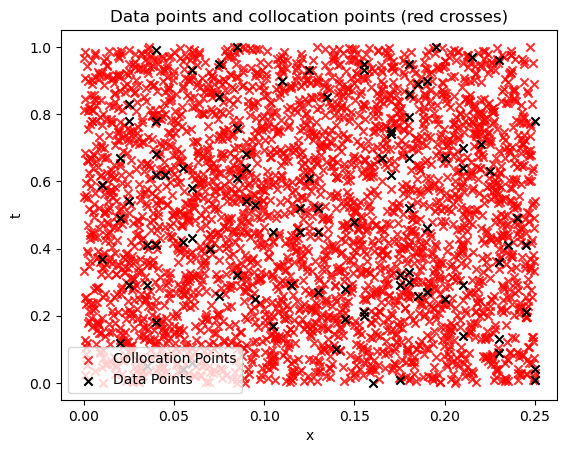

In [7]:
## Make a plot to show the distribution of training data
plt.scatter(X_f_train[:,1], X_f_train[:,0], marker='x', color='red',alpha=0.8)
plt.scatter(X_u_train[:,1], X_u_train[:,0], marker='x', color='black')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Data points and collocation points (red crosses)')
plt.legend(['Collocation Points', 'Data Points'])
plt.show()

<hr>
<div style="background-color: #ccffcc; padding: 10px;">

## Encoding of the network and physics constraint
The function **$u(x,t)$** that we seek is defined below as the function `net_u`; the physics constraint **$f(x,t)$** is defined in the function `net_f`
    
    
1. we read in the value of k first so that it can be included in the equations 
2. then we evaluate u for the X_f input coordinates (collocation points)
3. then we use pytorch differentiation (autograd) to calculate the derivatives of the solution
4. finally we encode the PDE in residual form, as f->0, u_t = k*u_xx, which is the governing equation
    
</div>



In [8]:
def net_u(x, t, model):
    X = torch.cat([x, t], dim=1)
    u = model(X)
    return u

def net_f(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = net_u(x, t, model)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    f = u_t - model.k * u_xx
    return f

# PyTorch module class and initialization

<div style="background-color: #ccffcc; padding: 10px;">

This code sets up a Physics-Informed Neural Network (PINN) for solving the 1D heat equation using PyTorch. Here's a summary of the key components:

1. `XavierInit` Class:

Custom layer initialization using Xavier initialization (https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/), which is designed to keep the scale of the gradients roughly the same in all layers.
Initializes weights and biases for a layer.

2. `initialize_NN` Function:

Creates a list of layers using the XavierInit class.
Takes a list of layer sizes and initializes each layer accordingly.

3. `NeuralNet()` constructs the network where the input and output coordinates are normalised so that all values lie between -1 and 1; this improves training. Applies the layers sequentially with the tanh activation function, except for the last layer.


Using the PyTorch module classes allow you to create more complex models controlling exactly how the data flows through the model [overview of PyTorch Modules here](https://www.learnpytorch.io/02_pytorch_classification/)

</div>

In [ ]:

class XavierInit(nn.Module):
    def __init__(self, size):
        super(XavierInit, self).__init__()
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = torch.sqrt(torch.tensor(2.0 / (in_dim + out_dim)))
        self.weight = nn.Parameter(torch.randn(in_dim, out_dim) * xavier_stddev)
        self.bias = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):
        return torch.matmul(x, self.weight) + self.bias

def initialize_NN(layers):
    weights = nn.ModuleList()
    num_layers = len(layers)
    for l in range(num_layers - 1):
        layer = XavierInit(size=[layers[l], layers[l + 1]])
        weights.append(layer)
    return weights

class NeuralNet(nn.Module):
    def __init__(self, layers, lb, ub,k_init):
        super(NeuralNet, self).__init__()
        self.weights = initialize_NN(layers)
        self.lb = torch.tensor(lb)
        self.ub = torch.tensor(ub)
        self.k = torch.tensor(k_init, dtype=torch.float32, requires_grad=True)
        

    def forward(self, X):
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(len(self.weights) - 1):
            H = torch.tanh(self.weights[l](H.float()))
        Y = self.weights[-1](H)
        return Y




<div style="background-color: #cce5ff; padding: 10px;">

### Note about Tensors in PyTorch

In PyTorch, tensors are the primary data structure used for storing and manipulating data. Below is an expanded explanation of setting up tensors, including requiring gradients and setting data types.

**Requiring Gradients**:
- To enable automatic differentiation, set `requires_grad=True` when creating a tensor. This allows PyTorch to track operations on the tensor and compute gradients during backpropagation.

**Data Types**:
  - PyTorch supports various data types, such as `float32`, `float64`, `int32`, `int64`, etc.
  - The data type can be specified using the `dtype` argument when creating a tensor, as your data types must match when performing operations
 

</div>

<div style="background-color: #ccffcc; padding: 10px;">

## Training

1. Initialize Loss Function and Optimizer:

* criterion = `nn.MSELoss()`
* optimizer = `torch.optim.Adam(model.parameters(), lr=learning_rate)`

2. Prepare Input Data:

Extract `x` and `t` from `X`. Convert `x`, `t`, and `u` to PyTorch tensors with `requires_grad=True`.


3. Training Loop:

* Loop over the number of iterations (nIter).
* Zero the gradients: optimizer.zero_grad().
* Predict u and the residual f using the model: u_pred and f_pred.
* Compute the loss:
    * `loss_PDE`: Mean Squared Error (MSE) between `f_pred` and zero.
    * `loss_data`: MSE between `u_tf` and `u_pred`.
    * Total loss: loss = loss_PDE + 5*loss_data.
* Backpropagate the loss: `loss.backward()`.
* Update the model parameters: `optimizer.step()`.

4. Print Progress:

Every 500 iterations, print the current iteration, loss, and elapsed time.

</div>

In [ ]:
def train(nIter, X, u, k,  model, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    start_time = time.time()
    x = X[:,0:1]
    t = X[:,1:2]
    
    x_tf = torch.tensor(x, requires_grad=True).float()
    t_tf = torch.tensor(t, requires_grad=True).float()
    u_tf = torch.tensor(u, requires_grad=True).float()
    loss_values = []
    for it in range(nIter):
        optimizer.zero_grad()
        u_pred = net_u(x_tf, t_tf, model )
        f_pred = net_f(x_tf, t_tf, model )
    
        loss_PDE = criterion(f_pred, torch.zeros(f_pred.shape))
        loss_data = criterion(u_tf, u_pred)
        loss = loss_PDE + 5*loss_data
        
        loss.backward()
        optimizer.step()
        # Print
        if it % 1000 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Loss: %.3e, Time: %.2f' % 
                          (it, loss.item(), elapsed))
            start_time = time.time()
        loss_values.append(loss.item())
        
    return loss_values


<div style="background-color: #ccffcc; padding: 10px;">

## Finally, you can train the model!

Training might take a while depending on the value of `Train_iterations` and also the specification of the machine you are running on.
If you set Train_iterations too low the end results will be unconverged. A value of 20000 was used to achieve excellent results.

Other are available in PyTorch, see [PyTorch Optimizers](https://pytorch.org/docs/stable/optim.html) for more information.


In [ ]:
#initialise model
model = NeuralNet(layers, lb, ub,k)

# Training
Train_iterations=30000


x = X_u_train[:,0:1]
t = X_u_train[:,1:2]

x_tf = torch.tensor(x, requires_grad=True)
t_tf = torch.tensor(t, requires_grad=True)
u_tf = torch.tensor(u_train, requires_grad=True)

u_pred = net_u(x_tf, t_tf, model )
f_pred = net_f(x_tf, t_tf, model)
model = model.float()
x_tf = x_tf.float()
t_tf = t_tf.float()
u_tf = u_tf.float()

loss_values = train(Train_iterations, X_u_train, u_train,k, model, learning_rate=1e-3)

In [ ]:

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss as a Function of Epochs')
plt.show()

<div style="background-color: #ccffcc; padding: 10px;">

# Use trained model to predict from data sample
    
The function `evaluate` will evaluate the solution `u` on a given grid using the trained model

</div>

In [ ]:
def evaluate(model, x_star, t_star):
    """
    Evaluate the solution u and the residual f of the 1D heat equation using the trained PINN model.

    Parameters:
    model (torch.nn.Module): The trained Physics-Informed Neural Network model.
    x_star (numpy.ndarray): Array of spatial points where predictions are to be made.
    t_star (numpy.ndarray): Array of temporal points where predictions are to be made.

    Returns:
    tuple: A tuple containing:
        - u_star (numpy.ndarray): Predicted solution at the given spatial and temporal points.
        - f_star (numpy.ndarray): Predicted residual of the PDE at the given spatial and temporal points.
    """
    # Convert input spatial points to a PyTorch tensor with gradient tracking enabled
    x_star_tf = torch.tensor(x_star, requires_grad=True)
    # Convert input temporal points to a PyTorch tensor with gradient tracking enabled
    t_star_tf = torch.tensor(t_star, requires_grad=True)
    # Evaluate the solution u using the model
    u_star = net_u(x_star_tf, t_star_tf, model)
    # Evaluate the residual f of the PDE using the model
    f_star = net_f(x_star_tf, t_star_tf, model)
     
    # Detach the Evaluations from the computation graph and convert to NumPy arrays
    return u_star.detach().numpy(), f_star.detach().numpy()

In [ ]:
u_eval, f_eval = evaluate(model,X_star[:,0:1],X_star[:,1:2])

error_u = np.linalg.norm(u_star-u_eval,2)/np.linalg.norm(u_star,2)

<div style="background-color: #ccffcc; padding: 10px;">

# Diagnostics: Errors
    
</div>

In [ ]:
print("Mean of physics residual = ", np.mean(f_eval))
print('Percent error in solution: ',  100*error_u)


<div style="background-color: #ccffcc; padding: 10px;">

# Plots of original, reconstructed solutions $u(x,t)$ and their difference
    


</div>

In [ ]:
# Set grid values back to full data set size for plotting

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
X, T = np.meshgrid(x,t) 

U_pred = u_eval.reshape(Exact.shape)
Error = np.abs(Exact - U_pred)
percentError = 100*np.divide(Error, Exact)


fig, ax = plt.subplots(figsize=(15,15))
ax.axis('off')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
X, T = np.meshgrid(x,t) 

U_pred = u_eval.reshape(Exact.shape)
Error = np.abs(Exact - U_pred)
percentError = 100*np.divide(Error, Exact)


####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(3, 1)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0, hspace=1)


########## Prediction ##################
ax = plt.subplot(gs0[0, :])
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto', vmin = 0, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[2]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[10]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x) - Prediction$', fontsize = 10)

########## Exact ##################
ax = plt.subplot(gs0[1, :])
i = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto', vmin = 0, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(i, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[2]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[10]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$ - Exact', fontsize = 10)

########## Error ##################
ax = plt.subplot(gs0[2, :])
j = ax.imshow(percentError.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto', vmin = 0, vmax = 10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(j, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[2]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[10]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$ - Percent difference', fontsize = 10)


####### Row 1: u(t,x) slices ##################

fig, ax = plt.subplots(figsize=(15,5))
ax.axis('off')
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[:, 0])
ax.plot(x,Exact[2,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[2,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = ' + str(t[2,0]) + '$', fontsize = 10)
ax.axis('square')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs1[:, 1])
ax.plot(x,Exact[5,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[5,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title('$t = ' + str(t[5,0]) + '$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[:, 2])
ax.plot(x,Exact[10,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[10,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title('$t = ' + str(t[10,0]) + '$', fontsize = 10);


<div style="background-color: #ccffcc; padding: 10px;">

## Summary of results

The relative error for recreating the full solution is at most $\approx 5 \%$ (and mostly much smaller), despite using only $N_u = 100$ data points. This shows the power of PINNs to learn from sparse measurements by augmenting the available observational data with knowledge of the underlying physics (i.e. governing equations). 

We can see that the errors are largest near $t=0$ and $x=0$, but that overall the agreement is very good.

On the colourmap, we can see three vertical white lines, which show the location in time of the three profile plots of $u$ against $x$. The three heat profiles at these times are plotted against the exact solution found using numerical methods. The profiles can be seen to be in very good agreement.

**Further Work**

Congratulations, you have now trained your first physics-informed neural network!

This network contains a number of hyper-parameters that could be tuned to give better results. Various hyper-parameters include:
- number of data training points N_u
- number of collocation training points N_f
- number of layers in the network
- number of neurons per layer
- weightings for the data and PDE loss terms in the loss function (currently we use loss = loss_PDE + 5*loss_data)

It is also possible to use different sampling techniques for training data points. We randomly select $N_u$ data points, but alternative methods could be choosing only boundary points or choosing more points near the $t=0$ boundary. Choosing boundary points for training could help to reduce the errors seen in these regions.

Feel free to try out some of these changes if you like!

</div>

# 1D Heat Equation: simultaneous inference of parameters and the solution 

<div style="background-color: #ccffcc; padding: 10px;">

So far, we have solved the heat equation

\begin{equation}
\frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2 }
\end{equation}

where $k$ has, up to this point, been assumed to be $k=1$. We now ask the question, what happens if we don't know $k$?
This corresponds to real-world problems where we may have observational data and knowledge of the governing equations, but lack information for some of the key parameters.

The network architecture for this example is the same as for the previous example. The only difference is that this time $k$ is added to the list of unknowns (weights and biases) that we seek to find. Through training, the network will then simultaneously discover the value of $k$ along with the solution. 

</div>


In [ ]:
## this is the k value used to generate the data
## we use this to compare to the value found by the PINN
k_exact = 1

# initialization inverse

<div style="background-color: #cce5ff; padding: 10px;">

Once you have run through the notebook once you may wish to alter any the following 
    
- number of data training points `N_u`
- number of collocation training points `N_f`
- number of layers in the network `layers`
- number of neurons per layer `layers`

</div>

In [ ]:
N_u = 100 #number of data points
N_f = 3000 # Colloaction points 
# structure of network: two inputs (x,t) and one output u
# 8 fully connected layers with 20 nodes per layer
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [ ]:
# This code is duplicated from above in case you have been playing with parameters
data = scipy.io.loadmat("Data/heatEquation_data.mat")
t = data['t'].flatten()[:,None] # read in t and flatten into column vector
x = data['x'].flatten()[:,None] # read in x and flatten into column vector
# 
Exact = np.real(data['usol']).T # Exact has structure of nx times nt

print("usol shape = ", Exact.shape)

# We need to find all the x,t coordinate pairs in the domain
X, T = np.meshgrid(x,t)

# Flatten the coordinate grid into pairs of x,t coordinates
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) # coordinates x,t
u_star = Exact.flatten()[:,None]   # corresponding solution value with each coordinate            

print("X has shape ", X.shape, ", X_star has shape ", X_star.shape)
    
# Doman bounds (-1,1)
lb = X_star.min(0)
ub = X_star.max(0)  

print("Lower bounds of x,t: ", lb)
print("Upper bounds of x,t: ", ub)


## Generate collocation points using Latin Hypercube sampling within the bounds of the spationtemporal coordinates
# Generate N_f x,t coordinates within range of upper and lower bounds
X_f_train = lb + (ub-lb)*lhs(2, N_f) # the 2 denotes the number of coordinates we have - x,t 
 
## We downsample the data to leave N_u randomly distributed points

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

<div style="background-color: #ccffcc; padding: 10px;">

We will use all the same functions as before except we will modify `k` and the training function to accommodate a variable `k` value which we seek. We will also set `k` as a `nn.Parameter` that will be updated in the training.     
    
</div>

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, layers, lb, ub,k_init):
        super(NeuralNet, self).__init__()
        self.weights = initialize_NN(layers)
        self.lb = torch.tensor(lb)
        self.ub = torch.tensor(ub)
        self.k = nn.Parameter(torch.tensor(k_init,dtype=torch.float32)) # will be picked up in model.parameters
        

    def forward(self, X):
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(len(self.weights) - 1):
            H = torch.tanh(self.weights[l](H.float()))
        Y = self.weights[-1](H)
        return Y

In [ ]:
def train(nIter, X, u,  model, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
    start_time = time.time()
    x = X[:,0:1]
    t = X[:,1:2]
    
    x_tf = torch.tensor(x, requires_grad=True).float()
    t_tf = torch.tensor(t, requires_grad=True).float()
    u_tf = torch.tensor(u, requires_grad=True).float()
    loss_values = []
    k_values = []
    for it in range(nIter):
        optimizer.zero_grad()
        u_pred = net_u(x_tf, t_tf, model )
        f_pred = net_f(x_tf, t_tf, model)
    
        loss_PDE = criterion(f_pred, torch.zeros(f_pred.shape))
        loss_data = criterion(u_tf, u_pred)
        loss = loss_PDE + 5*loss_data
        
        loss.backward()
        optimizer.step()

        # Print
        if it % 1000 == 0:
            elapsed = time.time() - start_time
            print(f'It: {it}, Loss: {loss.item():.3e}, Time: {elapsed:.2f}, k value: {model.k.item():.4f}, k.grad: {model.k.grad}')
            #print('It: %d, Loss: %.3e, Time: %.2f, k value: %.2f' % 
             #             (it, loss.item(), elapsed, model.k.item()))
            start_time = time.time()
        loss_values.append(loss.item())
        k_values.append(model.k.item())
        if (it + 1) % 5000 == 0:
            scheduler.step()
    return loss_values, k_values

In [ ]:
# initialise k as 10
k = 10
model = NeuralNet(layers,lb,ub,k)
x = X_u_train[:,0:1]
t = X_u_train[:,1:2]


x_t = torch.tensor(x, requires_grad=True)
t_t = torch.tensor(t, requires_grad=True)
u_t = torch.tensor(u_train, requires_grad=True)

u_pred = net_u(x_t, t_t, model)
f_pred = net_f(x_t, t_t, model)
model = model.float()
x_t = x_t.float()
t_t = t_t.float()
u_t = u_t.float()



In [ ]:
# Training
Train_iterations=30000
loss_values, k_values = train(Train_iterations, X_u_train, u_train, model, learning_rate=0.001)


In [ ]:
# Plot the loss values
plt.plot(k_values)
plt.xlabel('Epoch')
plt.ylabel(r'$k$')
#plt.yscale('log')
plt.title('K-value as a Function of Epochs')

<div style="background-color: #ccffcc; padding: 10px;">

The algorithm has converged to a value near $k=1$. Some fine-tuning might be required: consider different learning rates for `k` e.g. 

```python
optimizer_nn = torch.optim.Adam(model.weights, lr=0.001)  # For NN
optimizer_k = torch.optim.Adam([model.k], lr=0.0001)      # For k
```

Or consider more balanced loss weighting 
e.g 


```python
loss = loss_PDE + 2*loss_data
```


playing around with different optimizers might also a faster convergence and more accurate results, e.g. `SDG`

    
</div>

In [ ]:

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss as a Function of Epochs')
plt.show()

In [ ]:

u_eval, f_eval = evaluate(model,X_star[:,0:1],X_star[:,1:2])
error_u = np.linalg.norm(u_star - u_eval, 2)/np.linalg.norm(u_star, 2)

In [ ]:
print("f_pred mean = ", np.mean(f_eval))
print('Percent error u: ',  100*error_u)


In [ ]:
# Set grid values back to full data set size for plotting, because x,t is used also to describe the neural network.

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
X, T = np.meshgrid(x,t) 

U_pred = u_eval.reshape(Exact.shape)
Error = np.abs(Exact - U_pred)
percentError = 100*np.divide(Error, Exact)

fig, ax = plt.subplots(figsize=(15,15))
ax.axis('off')

print("--------- Errors ---------")
print('Percent error u: ',  100*error_u)
print("--------------------------")


####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(3, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0, hspace=1)


########## Prediction ##################
ax = plt.subplot(gs0[0, :])
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto', vmin = 0, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[2]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[10]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x) - Prediction$', fontsize = 10)

########## Exact ##################
ax = plt.subplot(gs0[1, :])
i = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto', vmin = 0, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(i, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[2]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[10]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$ - Exact', fontsize = 10)

########## Error ##################
ax = plt.subplot(gs0[2, :])
j = ax.imshow(percentError.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto', vmin = 0, vmax = 10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(j, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[2]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[10]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$ - Percent Error', fontsize = 10)

####### Row 1: u(t,x) slices ##################

fig, ax = plt.subplots(figsize=(15,15))
ax.axis('off')
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[:, 0])
ax.plot(x,Exact[2,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[2,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = ' + str(t[2,0]) + '$', fontsize = 10)
ax.axis('square')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax = plt.subplot(gs1[:, 1])
ax.plot(x,Exact[5,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[5,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title('$t = ' + str(t[5,0]) + '$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[:, 2])
ax.plot(x,Exact[10,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[10,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title('$t = ' + str(t[10,0]) + '$', fontsize = 10);

<div style="background-color: #ccffcc; padding: 10px;">

**Results**

Above are the results of the PINN. The error for recreating the full solution field is $\approx 5 \%$, despite using only $N_u = 100$ data points. This shows the power of PINNs to learn solution fields from sparse measurements, even when some of the input parameters are unknown.

The three colourmaps show the PINN prediction, the exact solution from the numerical method and the relative error between these two fields. We can see that the errors are largest near $t=0$ and $x=0$, but that overall the agreement is very good.

On the colourmap, we can see three vertical white lines, which show the location in time of the three profile plots of $u$ against $x$. The three heat profiles at these times are plotted against the exact solution found using numerical methods. The profiles can be seen to be in very good agreement, but show worse agreement.

</div>

<div style="background-color: #ffffcc ; padding: 10px;">

**Further Work**

Congratulations, you have now trained your second physics-informed neural network!

This network contains a number of hyper-parameters that could be tuned to give better results. Various hyper-parameters include:
- number of data training points N_u
- number of collocation training points N_f
- number of layers in the network
- number of neurons per layer
- weightings for the data and PDE loss terms in the loss function (currently we use loss = loss_PDE + 5*loss_data)
- initialisation value for k
- optimisation 

It is also possible to use different sampling techniques for training data points. We randomly select $N_u$ data points, but alternative methods could be choosing only boundary points or choosing more points near the $t=0$ boundary.

    
 </div>

<hr>


<div style="background-color: #ccffcc;; padding: 10px;">
    
# Next Steps
    
    
Next we move on to a more complex example using the Navier Stokes Equation in the next notebook 
    
 <hr>

    
</div>